In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)

## Preparing the Training Data

The training data is composed of pairs (x₁, x₂) so that x₂ consists of the value of the sine of x₁ for x₁ in the interval from 0 to 2π. You can implement it as follows:

In [3]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [7]:
train_data[:,1]

tensor([-0.9767, -0.5145,  0.9800,  ..., -0.9725, -0.0887, -0.7984])

In [11]:
train_data[:,0]

tensor([4.4960, 5.7428, 1.7710,  ..., 4.4772, 3.2305, 4.0663])

In [12]:
math.sin(4.4960)

-0.9766791164853464

In [13]:
train_set

[(tensor([ 4.4960, -0.9767]), tensor(0.)),
 (tensor([ 5.7428, -0.5145]), tensor(0.)),
 (tensor([1.7710, 0.9800]), tensor(0.)),
 (tensor([1.6217, 0.9987]), tensor(0.)),
 (tensor([ 3.9654, -0.7337]), tensor(0.)),
 (tensor([ 3.7702, -0.5881]), tensor(0.)),
 (tensor([ 5.8509, -0.4190]), tensor(0.)),
 (tensor([1.3527, 0.9763]), tensor(0.)),
 (tensor([ 3.7905, -0.6043]), tensor(0.)),
 (tensor([ 4.6042, -0.9942]), tensor(0.)),
 (tensor([1.1669, 0.9195]), tensor(0.)),
 (tensor([ 3.2048, -0.0632]), tensor(0.)),
 (tensor([ 4.7404, -0.9996]), tensor(0.)),
 (tensor([1.8120, 0.9710]), tensor(0.)),
 (tensor([ 3.6283, -0.4678]), tensor(0.)),
 (tensor([0.2252, 0.2233]), tensor(0.)),
 (tensor([0.6448, 0.6011]), tensor(0.)),
 (tensor([2.1483, 0.8378]), tensor(0.)),
 (tensor([2.7645, 0.3682]), tensor(0.)),
 (tensor([ 3.9842, -0.7464]), tensor(0.)),
 (tensor([ 3.9106, -0.6954]), tensor(0.)),
 (tensor([ 3.9801, -0.7436]), tensor(0.)),
 (tensor([ 5.3908, -0.7786]), tensor(0.)),
 (tensor([0.9877, 0.8348]), t

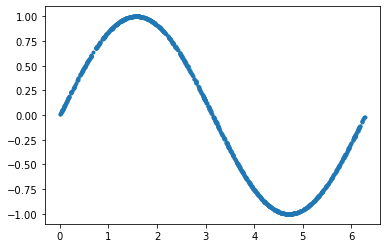

In [14]:
# Plot the data
plt.plot(train_data[:, 0], train_data[:, 1], ".")


In [15]:
# PyTorch data loader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

## Implementing the Discriminator

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [17]:
# Declare the Discriminator
discriminator = Discriminator()

## Implementing the Generator

In generative adversarial networks, the generator is the model that takes samples from a latent space as its input and generates data resembling the data in the training set.

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

## Training the Models

In [19]:
lr = 0.001
num_epochs = 300

# Binary cross entropy loss
loss_function = nn.BCELoss()

In [21]:
# Setting optimizers

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [22]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))
        
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        
        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.156594917178154
Epoch: 0 Loss G.: 2.125444173812866
Epoch: 10 Loss D.: 0.7301512956619263
Epoch: 10 Loss G.: 0.8579632043838501
Epoch: 20 Loss D.: 0.5808162689208984
Epoch: 20 Loss G.: 1.126640796661377
Epoch: 30 Loss D.: 0.5594370365142822
Epoch: 30 Loss G.: 0.8941763639450073
Epoch: 40 Loss D.: 0.5952788591384888
Epoch: 40 Loss G.: 1.000839114189148
Epoch: 50 Loss D.: 0.644279956817627
Epoch: 50 Loss G.: 0.9802781343460083
Epoch: 60 Loss D.: 0.6787832379341125
Epoch: 60 Loss G.: 0.9838975667953491
Epoch: 70 Loss D.: 0.6574348211288452
Epoch: 70 Loss G.: 0.717693030834198
Epoch: 80 Loss D.: 0.6049425005912781
Epoch: 80 Loss G.: 0.8287432789802551
Epoch: 90 Loss D.: 0.667488157749176
Epoch: 90 Loss G.: 0.7102006673812866
Epoch: 100 Loss D.: 0.6955989599227905
Epoch: 100 Loss G.: 0.6274586319923401
Epoch: 110 Loss D.: 0.7066787481307983
Epoch: 110 Loss G.: 0.7168657779693604
Epoch: 120 Loss D.: 0.675439178943634
Epoch: 120 Loss G.: 0.8128075003623962
Epoch: 130 Loss 

## Checking the Samples Generated by the GAN

In [23]:
# Lets generate some data using the generator that we have trained
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)


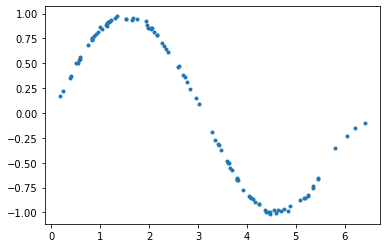

In [30]:
# Then plot the sample generated by the generated

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")